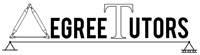
<center>www.DegreeTutors.com</center>

# 3D Frame Structures

## 1.0 Dependencies
Import libraries and dependencies

In [1]:
# DEPENDENCIES
import math #..............................................Math functionality
import copy #..............................................Create copies of objects in memory
import csv #...............................................Export deflected coords to csv file
import numpy as np #.......................................Numpy for working with arrays
from glob import glob #....................................Allows check that file exists before import
import matplotlib.colors #.................................Colormap functionality
import ipywidgets as widgets #.............................Widget control functionality
from numpy import genfromtxt #.............................Importing structure data from csv
import matplotlib.pyplot as plt #..........................Plotting functionality 
from mpl_toolkits.mplot3d import Axes3D #..................3D Plotting functionality
from mpl_toolkits.mplot3d.art3d import Poly3DCollection #..Plotting 3D patches

## 2.0 Automatic structure & loading data import
Import .csv data defining the structure and loading (generated in Blender)

In [2]:
#=================================START OF DATA IMPORT================================
#MANDATORY IMPORT: nodal coordinates
if glob('data/Vertices.csv'): 
    nodes = genfromtxt('data/Vertices.csv', delimiter=',') 
    print('1. 🟢 Vertices.csv imported')
else: 
    print('1. 🛑 STOP: Vertices.csv not found')

#MANDATORY IMPORT: member definitions
if glob('data/Edges.csv'): 
    members = genfromtxt('data/Edges.csv', delimiter=',')
    members = np.int_(members) 
    print('2. 🟢 Edges.csv imported')
else: 
    print('2. 🛑 STOP: Edges.csv not found')

#MANDATORY IMPORT: the supported nodes
if glob('data/Restraint-Nodes.csv'): 
    restraintNodes = genfromtxt('data/Restraint-Nodes.csv', delimiter=',')
    print('3. 🟢 Restraint-Nodes.csv imported')
else: 
    print('3. 🛑 STOP: Restraint-Nodes.csv not found')
    
#MANDATORY IMPORT: restrained DoF (index starting at 1) [Do multiple imports for different support types]
if glob('data/Restraint-DoF.csv'): 
    restraintData = genfromtxt('data/Restraint-DoF.csv', delimiter=',')
    restraintData = np.int_(restraintData) #Convert members definitions from float to int
    flatData = restraintData.flatten() #Flatten DoF data
    restrainedDoF = flatData[np.nonzero(flatData)[0]].tolist() #Remove zeros from DoF data
    print('4. 🟢 Restraint-DoF.csv imported')
else: 
    print('4. 🛑 STOP: Restraint-DoF.csv not found')
    
#OPTIONAL IMPORT: force location data
if glob('data/Force-Data.csv'): 
    forceLocationData = genfromtxt('data/Force-Data.csv', delimiter=',')
    forceLocationData = np.int_(forceLocationData) #Convert from float to int
    print('5. 🟢 Force-Data.csv imported')
else:
    forceLocationData = []
    print('5. ⚠️ Force-Data.csv not found')
#=================================END OF DATA IMPORT================================ 

1. 🟢 Vertices.csv imported
2. 🟢 Edges.csv imported
3. 🟢 Restraint-Nodes.csv imported
4. 🟢 Restraint-DoF.csv imported
5. 🟢 Force-Data.csv imported


## 3.0 Manual data entry
Enter constants, assign point load and distributed load magnitude and axis and indicate manual member rotations.

In [3]:
#=================================START OF MANUAL DATA ENTRY================================
#CONSTANTS
A_beam = 0.027385 #(m^2)
A_bar = 0.01 #(m^2)
YoungMod = 200*10**9 * np.ones([len(members)]) #(N/m^2)
ShearMod = 200*10**9 * np.ones([len(members)]) #(N/m^2)
Izz = 250*10**-6 * np.ones([len(members)]) #(m^4)
Iyy = 100*10**-6 * np.ones([len(members)]) #(m^4)
Ip = (Izz+Iyy) * np.ones([len(members)]) #(m^4)

#ASSIGN POINT LOADS
P = -1000 #(N) Point load magnitude (and direction via sign)
pointLoadAxis = 'z' #The GLOBAL axis along which point loads are applied

#=================================END OF MANUAL DATA ENTRY================================

## 5.0 Build an array of member areas
Define an individual cross-sectional area for each beam and bar element

In [4]:
Areas = A_beam*np.ones([len(members)]) #Initialise all member areas to beam area

## Plot structure to confirm before proceeding

In [5]:
def plotStructure(label_offset=0.01,
                 xMargin = 1,
                 yMargin = 1,
                 zMargin = 1,
                 elevation=30,
                 rotation=210):
    
    #Plot code
    fig = plt.figure() 
    axes = fig.add_axes([0.1,0.1,3,3],projection='3d') #Indicate a 3D plot 
    axes.view_init(elevation, rotation) #Set the viewing angle of the 3D plot
    
    #Set offset distance for node label
    dx = label_offset
    dy = label_offset
    dz = label_offset
    
    #Provide space/margin around the structure
    x_margin = xMargin
    y_margin = yMargin
    z_margin = zMargin
    
    #Plot members
    for n, mbr in enumerate(members):
        node_i = mbr[0] #Node number for node i of this member
        node_j = mbr[1] #Node number for node j of this member
                
        ix = nodes[node_i-1,0] #x-coord of node i of this member
        iy = nodes[node_i-1,1] #y-coord of node i of this member
        iz = nodes[node_i-1,2] #z-coord of node i of this member
        jx = nodes[node_j-1,0] #x-coord of node j of this member
        jy = nodes[node_j-1,1] #y-coord of node j of this member
        jz = nodes[node_j-1,2] #z-coord of node j of this member
        
        axes.plot3D([ix,jx],[iy,jy],[iz,jz],'b')
    
    #Plot nodes
    for n, node in enumerate(nodes):
        axes.plot3D([node[0]], [node[1]], [node[2]], 'bo', ms=6) #Plot 3D node
        label = str(n+1)
        axes.text(node[0]+dx, node[1]+dy, node[2]+dz, label, fontsize=16)
        
    #Set axis limits
    maxX = nodes.max(0)[0]
    maxY = nodes.max(0)[1]
    maxZ = nodes.max(0)[2]
    minX = nodes.min(0)[0]
    minY = nodes.min(0)[1]
    minZ = nodes.min(0)[2]
    axes.set_xlim([minX-x_margin, maxX+x_margin])
    axes.set_ylim([minY-y_margin, maxY+y_margin])
    axes.set_zlim([0, maxZ+z_margin])
    
    axes.set_xlabel('X-coordinate (m)')
    axes.set_ylabel('Y-coordinate (m)')
    axes.set_zlabel('Z-coordinate (m)')
    axes.set_title('Structure to Analyse')
    axes.grid()            
    
widgets.interact(plotStructure,
                label_offset=(0.01,0.1,0.01),
                xMargin=(0.25, 100, 0.25),
                yMargin=(0.25, 100, 0.25),
                zMargin=(0.5, 3, 0.25),
                elevation=(0,360,10),
                rotation=(0,360,10))

plt.show()

interactive(children=(FloatSlider(value=0.01, description='label_offset', max=0.1, min=0.01, step=0.01), FloatSlider(value=1.0, description='xMargin', min=0.25, step=0.25), FloatSlider(value=1.0, description='yMargin', min=0.25, step=0.25), FloatSlider(value=1.0, description='zMargin', max=3.0, min=0.5, step=0.25), IntSlider(value=30, description='elevation', max=360, step=10), IntSlider(value=210, description='rotation', max=360, step=10), Output()), _dom_classes=('widget-interact',))

## 8.0 Define a funtion to set the default member orientation
- Default 'y-up' orientation for non-vertical members
- Default 'y-left' orientation for vertical members
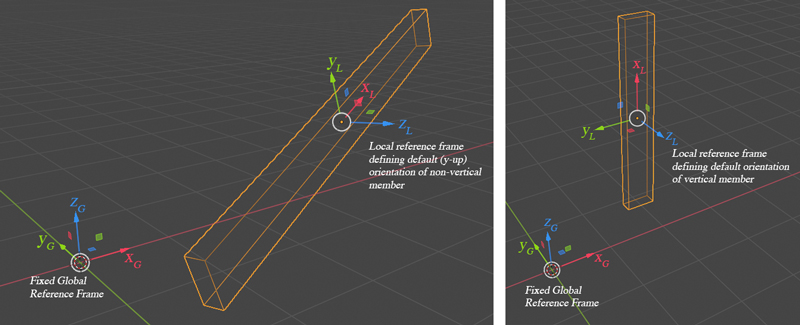

In [6]:
#Define a function to build a local reference frame in the default orientation
def buildLocalRF(memberNo):
    """
    For non-vertical members, the local x-y plane is determined by offsetting 
    the mid-point of the member vertically by +1m in the positive global z-direction.  
    
    For vertical members, the local x-y plan is determined by offsetting 
    the mid-point of the member by -1m in the negative global x-direction.
    
    Note that for all members: 
    - the local z-axis will be assumed to be the major principle axis
    - the local y-axis will be assumed to be the minor principle axis
    """
    
    memberIndex = memberNo -1 #Index identifying the member in the array of members
    node_i = members[memberIndex][0] #Node number for node i of this member    
    node_j = members[memberIndex][1] #Node number for node j of this member
    
    #Nodal coordinates
    ix = nodes[node_i-1][0]
    iy = nodes[node_i-1][1]
    iz = nodes[node_i-1][2]
    jx = nodes[node_j-1][0]
    jy = nodes[node_j-1][1]
    jz = nodes[node_j-1][2]
    
    #Member length
    dx = jx-ix #x-component of vector along member
    dy = jy-iy #y-component of vector along member
    dz = jz-iz #z-component of vector along member
    length = math.sqrt(dx**2 + dy**2 + dz**2) #Length if member
    
    if(abs(dx)<0.001 and abs(dy)<0.001):
        #Member is vertical - offset in negative global x to define local x-y plane
        i_offset = np.array([ix-1, iy, iz]) #Offset node i by 1m in negative global x-direction
        j_offset = np.array([jx-1, jy, jz]) #Offset node j by 1m in negative global x-direction
    else:
        #Member is not vertical - offset in positive global z to define local x-y plane
        i_offset = np.array([ix, iy, iz+1]) #Offset node i by 1m in positive global z-direction
        j_offset = np.array([jx, jy, jz+1]) #Offset node j by 1m in positive global z-direction
    node_k = i_offset + 0.5*(j_offset-i_offset) #Point in the local x-y plane
    
    #Local x-vector in the global reference frame running along the member
    local_x_vector = nodes[node_j-1] - nodes[node_i-1] #Vector along local x-axis
    local_x_unit = local_x_vector/length #Local unit vector defining local x-axis
    
    #Local y-vector in the global reference frame using Gram-Schmidt process
    vector_in_plane = node_k-nodes[node_i-1] #Vector in local x-y plane
    local_y_vector = vector_in_plane - np.dot(vector_in_plane,local_x_unit)*local_x_unit #local y-vector in global RF (Gram-Schmidt)
    magY = math.sqrt(local_y_vector[0]**2 + local_y_vector[1]**2+local_y_vector[2]**2) #Length of local y-vector
    local_y_unit = local_y_vector/magY #Local unit vector defining the local y-axis
    
    #Local z-vector in global RF using matrix cross product
    local_z_unit = np.cross(local_x_unit, local_y_unit) #Local unit vector defining the local z-axis
    
    #Combine reference frame into a standard rotation matrix for the element x,y,z => columns 1,2,3
    rotationMatrix = np.array([local_x_unit, local_y_unit, local_z_unit,]).T
    
    return [length, rotationMatrix]       

## 9.0 Build member orientation reference frames

In [7]:
#Determine orientation of each member
rotationMatrices = np.empty((len(members),3,3)) #Initialise data holder
lengths = np.zeros(len(members))

for n, mbr in enumerate(members):
    
    #Calculate the rotation matrix that defines the member orientation
    [length, rotationMatrix] = buildLocalRF(n+1)
    
    #Store rotation matrix and length
    rotationMatrices[n,:,:] = rotationMatrix
    lengths[n] = length        

## 10.0 Store the transformation matrix for each member
For convenience, store the repeating portion of the transformation matrix for each element

In [8]:
#Calculate the transformation matrix for each member
TransformationMatrices = np.empty((len(members),3,3)) #Initialise data holder

for n, mbr in enumerate(members):
    rMatrix = rotationMatrices[n,:,:] #Default orientation rotation matrix for this members
    TransformationMatrices[n,:,:] = rMatrix.T #For convenience, store transformation matrix directly

## 13.0 Build the global force vector and add point forces

In [9]:
#Initialise an empty force (& moment) vector
forceVector = np.array([np.zeros(len(nodes)*6)]).T 

#Add point loads to force vector
if(len(forceLocationData)>0):      
    #Split force location data (index starting at 0)
    forcedNodes = forceLocationData[:,0]
    xForceIndices = forceLocationData[:,1]
    yForceIndices = forceLocationData[:,2]
    zForceIndices = forceLocationData[:,3]
    xMomentIndices = forceLocationData[:,4]
    yMomentIndices = forceLocationData[:,5]
    zMomentIndices = forceLocationData[:,6]

    #Assign forces to degrees of freedom
    if(pointLoadAxis=='x'):
        forceVector[xForceIndices] = P 
    elif(pointLoadAxis=='y'):
        forceVector[yForceIndices] = P 
    else:
        forceVector[zForceIndices] = P 

## 16.0 Define a function to calculate the member global stiffness matrix
Function to build 12x12 global stiffness matrix for standard beam element

In [10]:
#Define a function to calculate the global stiffness matrix
def calculateKg3DBeam(memberNo):
    
    #Extract individual member properties
    A = Areas[memberNo-1]
    E = YoungMod[memberNo-1]
    L = lengths[memberNo-1]
    Iz = Izz[memberNo-1]
    Iy = Iyy[memberNo-1]
    G =  ShearMod[memberNo-1]
    J =  Ip[memberNo-1]
    
    Kl = np.zeros((12,12))
    #Row #1
    Kl[0,0] = E*A/L
    Kl[0,6] = -E*A/L
    #Row #2
    Kl[1,1] = 12*E*Iz/L**3
    Kl[1,5] = -6*E*Iz/L**2 
    Kl[1,7] = -12*E*Iz/L**3
    Kl[1,11] = -6*E*Iz/L**2
    #Row 3
    Kl[2,2] = 12*E*Iy/L**3 
    Kl[2,4] = 6*E*Iy/L**2 
    Kl[2,8] = -12*E*Iy/L**3 
    Kl[2,10] = 6*E*Iy/L**2
    #Row 4
    Kl[3,3] = G*J/L
    Kl[3,9] = -G*J/L
    #Row 5
    Kl[4,2] = 6*E*Iy/L**2
    Kl[4,4] = 4*E*Iy/L
    Kl[4,8] = -6*E*Iy/L**2
    Kl[4,10] = 2*E*Iy/L
    #Row 6
    Kl[5,1] = -6*E*Iz/L**2 
    Kl[5,5] = 4*E*Iz/L
    Kl[5,7] = 6*E*Iz/L**2
    Kl[5,11] = 2*E*Iz/L
    #Row 7
    Kl[6,0] = -E*A/L
    Kl[6,6] = E*A/L
    #Row 8
    Kl[7,1] = -12*E*Iz/L**3
    Kl[7,5] = 6*E*Iz/L**2
    Kl[7,7] = 12*E*Iz/L**3
    Kl[7,11] = 6*E*Iz/L**2
    #Row 9
    Kl[8,2] = -12*E*Iy/L**3
    Kl[8,4] = -6*E*Iy/L**2
    Kl[8,8] = 12*E*Iy/L**3
    Kl[8,10] = -6*E*Iy/L**2
    #Row 10
    Kl[9,3] = -G*J/L
    Kl[9,9] = G*J/L
    #Row 11
    Kl[10,2] = 6*E*Iy/L**2 
    Kl[10,4] = 2*E*Iy/L
    Kl[10,8] = -6*E*Iy/L**2
    Kl[10,10] = 4*E*Iy/L
    #Row 12
    Kl[11,1] = -6*E*Iz/L**2
    Kl[11,5] = 2*E*Iz/L
    Kl[11,7] = 6*E*Iz/L**2
    Kl[11,11] = 4*E*Iz/L
    
    #Build the full transformation matrix for this element
    TM = np.zeros((12,12))
    T_repeat = TransformationMatrices[memberNo-1,:,:]
    TM[0:3,0:3] = T_repeat
    TM[3:6,3:6] = T_repeat
    TM[6:9,6:9] = T_repeat
    TM[9:12,9:12] = T_repeat
    
    #Calculate the global element stiffness matrix
    Kg = TM.T.dot(Kl).dot(TM)
    
    K11g = Kg[0:6,0:6]
    K12g = Kg[0:6,6:12]
    K21g = Kg[6:12,0:6]
    K22g = Kg[6:12,6:12]
    
    return [K11g, K12g, K21g, K22g]


## 20.0 Build the primary stiffness matrix, Kp

In [11]:
nDoF = np.amax(members)*6 #The total number of degrees of freedom in the problem
Kp = np.zeros([nDoF,nDoF]) #Initialise the primary stiffness matrix

for n, mbr in enumerate(members):
    node_i = mbr[0] #Node number for node i of this member    
    node_j = mbr[1] #Node number for node j of this member
    
    [K11, K12, K21, K22] = calculateKg3DBeam(n+1)
    #Primary stiffness matrix indices associated with each node
    ia = 6*node_i-6 #index 0 (e.g. node 1)
    ib = 6*node_i-1 #index 5 (e.g. node 1)
    ja = 6*node_j-6 #index 6 (e.g. node 2)
    jb = 6*node_j-1 #index 11 (e.g. node 2)
    
    Kp[ia:ib+1, ia:ib+1] = Kp[ia:ib+1, ia:ib+1] + K11
    Kp[ia:ib+1, ja:jb+1] = Kp[ia:ib+1, ja:jb+1] + K12
    Kp[ja:jb+1, ia:ib+1] = Kp[ja:jb+1, ia:ib+1] + K21
    Kp[ja:jb+1, ja:jb+1] = Kp[ja:jb+1, ja:jb+1] + K22   


## 21.0 Extract structure stiffness matrix, Ks
Remove restrained (and rotational) released degrees of freedom to produce the structure stiffness matrix

In [12]:
#Remove restrained degrees of freedom
removedDoF = restrainedDoF #(later we'll add in pinned DoF here)
removedIndex = [x-1 for x in removedDoF] #Index for each removed DoF

#Reduce to structure stiffness matrix by deleting rows and columns for removed DoF
Ks = np.delete(Kp,removedIndex,0) #Delete rows
Ks = np.delete(Ks,removedIndex,1) #Delete columns
Ks = np.matrix(Ks)

## 22.0 Solve for displacements

In [13]:
forceVectorRed = copy.copy(forceVector)
forceVectorRed = np.delete(forceVectorRed,removedIndex,0) #Delete rows corresponding to restrained DoF
U = Ks.I*forceVectorRed

## 23.0 Solve for reactions

In [14]:
#Construct global displacement vector
UG = np.zeros(nDoF) #Initialise an array to hold the global displacement vector
c=0 #Initialise a counter to track how many restraints have been imposed

for i in np.arange(nDoF):
    if i in removedIndex:
        #Impose zero displacement
        UG[i] = 0
    else:
        #Assign actual displacement
        UG[i] = U[c]
        c=c+1
        
UG = np.array([UG]).T
FG = np.matmul(Kp,UG)

## 24.0 Solve for member Actions (Axial forces, BM and Shear)

In [15]:
mbrForceX = np.array([]) #Initialise an array to hold member axial forces
mbrForceY = np.zeros(members.shape) #Initialise an array to hold member shear forces
mbrForceZ = np.zeros(members.shape) #Initialise an array to hold member transverse forces
mbrMomentX = np.zeros(members.shape) #Initialise an array to hold member torsional moments
mbrMomentY = np.zeros(members.shape) #Initialise an array to hold member minor axis moments
mbrMomentZ = np.zeros(members.shape) #Initialise an array to hold member major axis moments

for n,mbr in enumerate(members):  

    #Extract individual member properties
    A = Areas[n]
    E = YoungMod[n]
    L = lengths[n]
    Iz = Izz[n]
    Iy = Iyy[n]
    G =  ShearMod[n]
    J =  Ip[n]
    
    node_i = mbr[0] #Node number for node i of this member    
    node_j = mbr[1] #Node number for node j of this member

    #Primary stiffness matrix indices associated with each node
    ia = 6*node_i-6 #index 0 (e.g. node 1)
    ib = 6*node_i-1 #index 5 (e.g. node 1)
    ja = 6*node_j-6 #index 6 (e.g. node 2)
    jb = 6*node_j-1 #index 11 (e.g. node 2)
    
    #Build the full transformation matrix for this element
    TM = np.zeros((12,12))
    T_repeat = TransformationMatrices[n,:,:]
    TM[0:3,0:3] = T_repeat
    TM[3:6,3:6] = T_repeat
    TM[6:9,6:9] = T_repeat
    TM[9:12,9:12] = T_repeat
    
    disp = np.array([[ UG[ia,0],
                       UG[ia+1,0],
                       UG[ia+2,0],
                       UG[ia+3,0],
                       UG[ia+4,0],
                       UG[ib,0],
                       UG[ja,0],
                       UG[ja+1,0],
                       UG[ja+2,0],
                       UG[ja+3,0],
                       UG[ja+4,0],
                       UG[jb,0]]]).T
    
    disp_local = np.matmul(TM,disp)
    
    F_axial = (A*E/L)*(disp_local[6] - disp_local[0])[0]
    
    #Caclulate the quadrants of the global stiffness matrix for the member
    [K11, K12, K21, K22] = calculateKg3DBeam(n+1)
    top = np.concatenate((K11,K12),axis=1) #Top 6 rows
    btm = np.concatenate((K21,K22),axis=1) #Bottom 6 rows
    Kg = np.concatenate((top,btm), axis=0) #Full global stiffness matrix
    
    #Convert back to local stiffness matrix
    Kl = TM.dot(Kg).dot(TM.T)
    
    #Compute moments at each end of the member
    Mix = Kl[3,:].dot(disp_local)[0]
    Mjx = Kl[9,:].dot(disp_local)[0]
    
    Miy = Kl[4,:].dot(disp_local)[0]
    Mjy = Kl[10,:].dot(disp_local)[0]
    
    Miz = Kl[5,:].dot(disp_local)[0]
    Mjz = Kl[11,:].dot(disp_local)[0]
    
    #Compute shear forces at each end of the member
    Fy_i = Kl[1,:].dot(disp_local)[0]
    Fy_j = Kl[7,:].dot(disp_local)[0]
    
    Fz_i = Kl[2,:].dot(disp_local)[0]
    Fz_j = Kl[8,:].dot(disp_local)[0]
    
    #Store member actions
    mbrForceX = np.append(mbrForceX,F_axial)
    mbrForceY[n,0] = Fy_i
    mbrForceY[n,1] = Fy_j    
    mbrForceZ[n,0] = Fz_i
    mbrForceZ[n,1] = Fz_j     
    mbrMomentX[n,0] = Mix
    mbrMomentX[n,1] = Mjx
    mbrMomentY[n,0] = Miy
    mbrMomentY[n,1] = Mjy
    mbrMomentZ[n,0] = Miz
    mbrMomentZ[n,1] = Mjz  

## 27.0 Plot deflected shape

In [16]:
def plotDeflection(xMargin=1, 
                   yMargin=1, 
                   zMargin=0.5, 
                   elevation=30, 
                   rotation=210, 
                   scaleFactor=1):
    
    fig = plt.figure()
    axes = fig.add_axes([0.1,0.1,2.5,2.5],projection='3d') 
    axes.view_init(elevation, rotation)

    #Provide space/margin around structure
    x_margin = xMargin #x-axis margin
    y_margin = yMargin #y-axis margin
    z_margin = zMargin #z-axis margin
    
    #Plot members
    for mbr in members:
        node_i = mbr[0] #Node number for node i of this member
        node_j = mbr[1] #Node number for node j of this member   

        ix = nodes[node_i-1,0] #x-coord of node i of this member
        iy = nodes[node_i-1,1] #y-coord of node i of this member
        iz = nodes[node_i-1,2] #z-coord of node i of this member
        jx = nodes[node_j-1,0] #x-coord of node j of this member
        jy = nodes[node_j-1,1] #y-coord of node j of this member
        jz = nodes[node_j-1,2] #z-coord of node j of this member

        #Index of DoF for this member   
        ia = 6*node_i-6 #index 0 (e.g. node 1)
        ib = 6*node_i-4 #index 2 (e.g. node 1)
        ja = 6*node_j-6 #index 6 (e.g. node 2)
        jb = 6*node_j-4 #index 8 (e.g. node 2)
        
        axes.plot3D([ix, jx], [iy, jy], [iz, jz], 'grey', lw=0.75) #Member
        axes.plot3D([ix + UG[ia,0]*scaleFactor, jx + UG[ja,0]*scaleFactor], 
                    [iy + UG[ia+1,0]*scaleFactor, jy + UG[ja+1,0]*scaleFactor], 
                    [iz + UG[ib,0]*scaleFactor, jz + UG[jb,0]*scaleFactor], 
                    'r') # Deflected member
        
        
    #Set axis limits
    maxX = nodes.max(0)[0]
    maxY = nodes.max(0)[1]
    maxZ = nodes.max(0)[2]
    minX = nodes.min(0)[0]
    minY = nodes.min(0)[1]
    minZ = nodes.min(0)[2]
    axes.set_xlim([minX-x_margin, maxX+x_margin])
    axes.set_ylim([minY-y_margin, maxY+y_margin])
    axes.set_zlim([0, maxZ+z_margin])
    
    axes.set_xlabel('X-coordinate (m)')
    axes.set_ylabel('Y-coordinate (m)')
    axes.set_zlabel('Z-coordinate (m)')
    axes.set_title('Deflected Shape')
    axes.grid()            
    
#Widget code
widgets.interact(plotDeflection,
                 xMargin=(0.25, 100, 0.25),
                 yMargin=(0.25, 100, 0.25),
                 zMargin=(0.5, 100, 0.25),
                 elevation=(0,360,10),
                 rotation=(0,360,10),
                 scaleFactor=(1,500,50))

plt.show()

interactive(children=(FloatSlider(value=1.0, description='xMargin', min=0.25, step=0.25), FloatSlider(value=1.0, description='yMargin', min=0.25, step=0.25), FloatSlider(value=0.5, description='zMargin', min=0.5, step=0.25), IntSlider(value=30, description='elevation', max=360, step=10), IntSlider(value=210, description='rotation', max=360, step=10), IntSlider(value=1, description='scaleFactor', max=500, min=1, step=50), Output()), _dom_classes=('widget-interact',))

## 28.0 Plot Axial Forces

In [17]:
def plotForces(xMargin=1, 
               yMargin=1, 
               zMargin=0.5, 
               elevation=30, 
               rotation=210,
               label_offset=0.15, 
               font_size=8,
               Labels='None',
               Reactions='Show'):
    
    fig = plt.figure()
    axes = fig.add_axes([0.1,0.1,2.5,2.5],projection='3d') 
    axes.view_init(elevation, rotation)

    #Provide space/margin around structure
    x_margin = xMargin #x-axis margin
    y_margin = yMargin #y-axis margin
    z_margin = zMargin #z-axis margin
    
    #Change colormap based on distribution of axial forces
    if(mbrForceX.min()<0 and mbrForceX.max()<0):
        #All member forces are compression
        norm = matplotlib.colors.DivergingNorm(vmin=mbrForceX.min(),
                                              vcenter = mbrForceX.min() + 0.5*(mbrForceX.max()-mbrForceX.min()),
                                              vmax = mbrForceX.max())

        cmap = plt.cm.Reds_r #Defining the color scale to use (note _r reverses the colormap)
        
    elif(mbrForceX.min()>0 and mbrForceX.max()>0):
        #All member forces are tension
        norm = matplotlib.colors.DivergingNorm(vmin=mbrForceX.min(),
                                              vcenter = mbrForceX.min() + 0.5*(mbrForceX.max()-mbrForceX.min()),
                                              vmax = mbrForceX.max())
        cmap = plt.cm.Blues_r
        
    else:
        norm = matplotlib.colors.DivergingNorm(vmin=mbrForceX.min(),
                                              vcenter = 0,
                                              vmax = mbrForceX.max())
        cmap = plt.cm.seismic_r
        
    #Add color scale to figure
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    fig.colorbar(sm)
    
    
    #Plot members
    for n, mbr in enumerate(members):
        node_i = mbr[0] #Node number for node i of this member
        node_j = mbr[1] #Node number for node j of this member   

        ix = nodes[node_i-1,0] #x-coord of node i of this member
        iy = nodes[node_i-1,1] #y-coord of node i of this member
        iz = nodes[node_i-1,2] #z-coord of node i of this member
        jx = nodes[node_j-1,0] #x-coord of node j of this member
        jy = nodes[node_j-1,1] #y-coord of node j of this member
        jz = nodes[node_j-1,2] #z-coord of node j of this member

        #Index of DoF for this member   
        ia = 6*node_i-6 #index 0 (e.g. node 1)
        ib = 6*node_i-4 #index 2 (e.g. node 1)
        ja = 6*node_j-6 #index 6 (e.g. node 2)
        jb = 6*node_j-4 #index 8 (e.g. node 2)
                
        if(abs(mbrForceX[n])>0.001):
            axes.plot3D([ix,jx],[iy,jy],[iz,jz], color=cmap(norm(mbrForceX[n]))) #Non-zero force member
        else:
            axes.plot3D([ix,jx],[iy,jy],[iz,jz], 'grey', linestyle='--')
            
        
        #Plot labels on nodes at each end of member
        if(Labels=='Fx' and abs(mbrForceX[n])>0.001):
            Fx = round(mbrForceX[n]/1000,1)
            label = "Mbr " + str(n+1) + '(' + str(node_i)+'/'+str(node_j)+')' +"\n" + str(Fx) + "kN"
            xPos = ix + 0.5*(jx-ix)+label_offset
            yPos = iy + 0.5*(jy-iy)+label_offset
            zPos = iz + 0.5*(jz-iz)+label_offset
            axes.text(xPos, yPos, zPos, label,fontsize=font_size, bbox = dict(facecolor='grey', alpha=0.1))
                    
    #Plot nodes
    for node in nodes:
        axes.plot3D([node[0]], [node[1]], [node[2]], 'go', ms=1) #Plot 3D node
 
    #Plot reaction labels
    if(Reactions=='Show'):
        for r in restraintNodes:
            r = int(r)
            Rx = round(FG[6*r-6].item()/1000,2)
            Ry = round(FG[6*r-5].item()/1000,2)
            Rz = round(FG[6*r-4].item()/1000,2)
            Mx = round(FG[6*r-3].item()/1000,2)
            My = round(FG[6*r-2].item()/1000,2)
            Mz = round(FG[6*r-1].item()/1000,2)
            ix = nodes[r-1,0] #x-coord of node i of this member
            iy = nodes[r-1,1] #y-coord of node i of this member
            iz = nodes[r-1,2] #z-coord of node i of this member
            xPos = ix + label_offset
            yPos = iy + label_offset
            zPos = iz + label_offset
            rLabel = "Node " + str(r)+'\n'+'Fx: '+str(Rx)+' kN'+'\n'+'Fy: '+str(Ry)+' kN'+'\n'+'Fz: '+str(Rz)+' kN'+'\n'+'Mx: '+str(Mx)+' kNm'+'\n'+'My: '+str(My)+' kNm'+'\n'+'Mz: '+str(Mz)+' kNm'
            axes.text(xPos, yPos, zPos, rLabel,fontsize=font_size, bbox = dict(facecolor='grey', alpha=0.1))
            
    #Set axis limits
    maxX = nodes.max(0)[0]
    maxY = nodes.max(0)[1]
    maxZ = nodes.max(0)[2]
    minX = nodes.min(0)[0]
    minY = nodes.min(0)[1]
    minZ = nodes.min(0)[2]
    axes.set_xlim([minX-x_margin, maxX+x_margin])
    axes.set_ylim([minY-y_margin, maxY+y_margin])
    axes.set_zlim([0, maxZ+z_margin])
    
    axes.set_xlabel('X-coordinate (m)')
    axes.set_ylabel('Y-coordinate (m)')
    axes.set_zlabel('Z-coordinate (m)')
    axes.set_title('Tension/compression members')
    axes.grid()      
        
#Call the interact widget    
widgets.interact(plotForces, 
                 xMargin=(0.25, 100, 0.25),
                 yMargin=(0.25, 100, 0.25),
                 zMargin=(0.5, 100, 0.25),
                 elevation=(0,360,10),
                 rotation=(0,360,10),
                 label_offset=(-1, 1, 0.1), 
                 font_size=(8,14,1),
                 Labels= ['Fx', 'None'],
                 Reactions=['Show', 'Hide'])
        
plt.show()

interactive(children=(FloatSlider(value=1.0, description='xMargin', min=0.25, step=0.25), FloatSlider(value=1.0, description='yMargin', min=0.25, step=0.25), FloatSlider(value=0.5, description='zMargin', min=0.5, step=0.25), IntSlider(value=30, description='elevation', max=360, step=10), IntSlider(value=210, description='rotation', max=360, step=10), FloatSlider(value=0.15, description='label_offset', max=1.0, min=-1.0), IntSlider(value=8, description='font_size', max=14, min=8), Dropdown(description='Labels', index=1, options=('Fx', 'None'), value='None'), Dropdown(description='Reactions', options=('Show', 'Hide'), value='Show'), Output()), _dom_classes=('widget-interact',))

## 29.0 Bending and Torsion Moment Diagrams
First build the bending moment diagram in the local member reference frame then transform it to the global position and orientation of the member.

### 29.1 Helper function - Build diagram in local member reference frame

In [18]:
def buildLocalMemberBMD(n, axis, momentScale, length):
    """
    Build the coords of the BMD patch in the local member RF
    """
    
    if(axis=='z'):
        mi = mbrMomentZ[n,0]*momentScale
        mj = mbrMomentZ[n,1]*momentScale
    elif(axis=='y'):
        mi = mbrMomentY[n,0]*momentScale
        mj = mbrMomentY[n,1]*momentScale
    elif(axis=='x'):
        mi = mbrMomentX[n,0]*momentScale
        mj = mbrMomentX[n,1]*momentScale
        
    #Correct the shape of the segment BMD
    if(mi<0 and mj>0):
        mi = abs(mi)
        mj = abs(mj)
    elif(mi<0 and mj<0):
        mi = abs(mi)
        mj = -abs(mj)
    elif(mi>0 and mj>0):
        mi = -abs(mi)
        mj = abs(mj)
    elif(mi>0 and mj<0):
        mi = -abs(mi)
        mj = -abs(mj)
    elif(mi>0 and mj==0):
        mi = -abs(mi)
    elif(mi<0 and mj==0):
        mi = abs(mi)
        
    #Define [x,y,z] coords of each corner of patch defining the BMD
    if(axis=='z' or axis=='x'):
        pt1 = np.array([0,0,0]) #Bottom left
        pt2 = np.array([0,mi,0]) #Top left
        pt3 = np.array([length,mj,0]) #Top right
        pt4 = np.array([length,0,0]) #Bottom right
    elif(axis=="y"):
        pt1 = np.array([0,0,0]) #Bottom left
        pt2 = np.array([0,0,-mi]) #Top left (ensures correct orientation to y-axis diagram)
        pt3 = np.array([length,0,-mj])#Top right (ensures correct orientation to y-axis diagram)
        pt4 = np.array([length,0,0])# Bottom right
            
    return [pt1, pt2, pt3, pt4]           

**<sub>Copyright &copy; 2021, S.P.Carroll. All rights reserved</sub>**